In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
import re
import geopandas as gpd
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Create OD datasets

In [ ]:
def GET_OD_DATA(df, columns_to_drop):
    """
    Process the LU linkload data to create an undirected network DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame containing LU linkload data.
        columns_to_drop (list): List of column names to drop from the DataFrame.

    Returns:
        pd.DataFrame: Processed DataFrame with an undirected network.
    """
    # Drop specified columns
    df_simplified = df.drop(columns=columns_to_drop)

    # Remove self-loops
    df_simplified = df_simplified[df_simplified['from_station'] != df_simplified['to_station']]

    # Get value columns (exclude 'from_station' and 'to_station')
    value_columns = df_simplified.columns.difference(['from_station', 'to_station'])

    # Create a unique identifier for undirected pairs
    df_simplified['pair'] = df_simplified.apply(
        lambda row: tuple(sorted([row['from_station'], row['to_station']])), axis=1
    )

    # Sum up values for the same undirected pair
    grouped = df_simplified.groupby('pair')[value_columns].sum().reset_index()

    # Split the 'pair' column back into 'from_station' and 'to_station'
    grouped[['from_station', 'to_station']] = pd.DataFrame(grouped['pair'].tolist(), index=grouped.index)

    # Drop the 'pair' column
    df_undirected = grouped.drop(columns=['pair'])

    # Reorder columns
    columns_order = [col for col in df_simplified.columns if col != 'pair']
    df_undirected = df_undirected[columns_order]

    return df_undirected

# Monday to Thursday
mtt_LU_linkload = pd.read_csv("/content/drive/MyDrive/INFSCI_2125_Final_project/data/cleaned_data/LU_linkload_mtt_2022_cleaned.csv")
# Friday
fri_LU_linkload = pd.read_csv("/content/drive/MyDrive/INFSCI_2125_Final_project/data/cleaned_data/LU_linkload_fri_2022_cleaned.csv")
# Saturday
sat_LU_linkload = pd.read_csv("/content/drive/MyDrive/INFSCI_2125_Final_project/data/cleaned_data/LU_linkload_sat_2022_cleaned.csv")
# Sunday
sun_LU_linkload = pd.read_csv("/content/drive/MyDrive/INFSCI_2125_Final_project/data/cleaned_data/LU_linkload_sun_2022_cleaned.csv")

columns_to_drop = ['link', 'line', 'dir', 'order', 'from_nlc', 'from_asc', 'to_nlc', 'to_asc']

# GET od datasets (UNDIRECTED)
fri_OD = GET_OD_DATA(fri_LU_linkload, columns_to_drop)
mtt_OD = GET_OD_DATA(mtt_LU_linkload, columns_to_drop)
sat_OD = GET_OD_DATA(sat_LU_linkload, columns_to_drop)
sun_OD = GET_OD_DATA(sun_LU_linkload, columns_to_drop)

In [ ]:
# number of station in this dataset
unique_stations = pd.concat([sun_OD['from_station'], sun_OD['to_station']]).unique()
unique_count = len(unique_stations)
print(f"Number of station: {unique_count}")

Number of station: 270


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## If London underground network has small-world property?

### Topological Structure Visualisation

<Figure size 1200x1200 with 0 Axes>

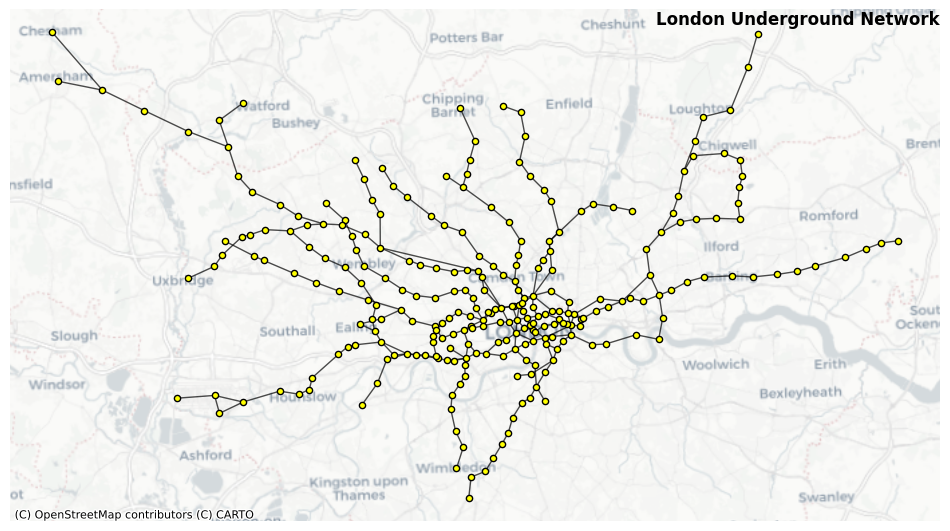

In [ ]:
G_topo = nx.from_pandas_edgelist(sun_OD, 'from_station', 'to_station', create_using=nx.Graph())
print(f'Number of connected components:{nx.number_connected_components(G_topo)}')

!pip install contextily
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx  #basemap

## read gdf file
file_path = "/content/drive/MyDrive/INFSCI_2125_Final_project/data/cleaned_data/London stations.shp"
gdf = gpd.read_file(file_path)

## clean names
for node, data in list(G_topo.nodes(data=True)):
    if 'Hammersmith' in str(node) and '(H' in str(node):
        new_node_name = "Hammersmith"
        G_topo = nx.relabel_nodes(G_topo, {node: new_node_name})

gdf['Name'] = gdf['Name'].replace(r".*Hammersmith.*Met.*", "Hammersmith", regex=True)

# name processing function
def preprocess_station_name(name):
    # remove "LU"
    name = name.replace("LU", "").strip()
    name = name.replace("TfL", "").strip()
    # replace "&" 为 "and"
    name = name.replace("&", "and")
    # remove single quote
    name = name.replace("'", "")
    # Special Marker Replacement
    name = name.replace("Edgware Road (DIS)", "Edgware Road (Circle/District/Hammersmith and City)")
    name = name.replace("(DIS)", "(District)")
    name = name.replace("(Bak)", "(Bakerloo)")
    name = name.replace("(H&C)", "(Met.)")
    name = name.replace("Bank and Monument", "Monument")
    name = name.replace("Heathrow Terminals 123", "Heathrow Terminals 1 2 3")
    name = name.replace("Hammersmith", "Hammersmith \\(Met\\.\\)")
    #name = name.replace(r"Hammersmith \(H&C\)", "Hammersmith (Met.)", regex=True)


    return name.strip()

gdf['Name'] = gdf['Name'].replace(r"Hammersmith \\(Met\\.\\)", "Hammersmith", regex=True)
gdf['Name'] = gdf['Name'].apply(preprocess_station_name)

## Adding geographic information to G_topo's nodes
for node in G_topo.nodes:
    processed_node = preprocess_station_name(node)
    station_info = gdf[gdf['Name'] == processed_node]
    G_topo.nodes[node]['geometry'] = station_info.iloc[0].geometry

## Plotting
plt.figure(figsize=(12, 12))

node_positions = {
    node: (data['geometry'].x, data['geometry'].y)
    for node, data in G_topo.nodes(data=True) if 'geometry' in data
}

nodes_gdf = gpd.GeoDataFrame(
    {
        'node': list(node_positions.keys()),
        'geometry': [gpd.points_from_xy([x], [y])[0] for x, y in node_positions.values()]
    },
    crs='EPSG:4326'
)

nodes_gdf = nodes_gdf.to_crs('EPSG:27700')

node_positions_transformed = {
    node: (geom.x, geom.y)
    for node, geom in zip(nodes_gdf['node'], nodes_gdf['geometry'])
}

# Map base map (with London area in the background)
ax = nodes_gdf.plot(
    figsize=(12, 12), color='none', edgecolor='none'
)

ctx.add_basemap(ax, crs=nodes_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
#ctx.add_basemap(ax, crs=nodes_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

nx.draw_networkx_edges(
    G_topo,
    pos=node_positions_transformed,
    edge_color='black',
    alpha=0.7,
    ax=ax
)

nx.draw_networkx_nodes(
    G_topo,
    pos=node_positions_transformed,
    node_size=20,
    node_color='yellow',
    edgecolors='black',
    linewidths=1,
    ax=ax
)
ax.axis('off')
#plt.title("London Tube Network with Geographic Positions", fontsize=16)
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.grid(False)

plt.text(
    1.0, 0.97,
    "London Underground Network",
    fontsize=12,
    fontweight='bold',
    ha='right',
    transform=ax.transAxes
)

plt.show()

### Topological Network Small-World Property Assessment

In [ ]:
def assess_small_world_properties_topology(G_actual, num_iterations=50):
    """
    Assess small-world properties of a given network compared to random graphs.

    Parameters:
        G_actual (networkx.Graph): The actual network to analyze.
        num_iterations (int): The number of iterations to run for random graph generation.

    Returns:
        dict: A dictionary containing the clustering coefficient, path length,
              and small-world assessment results.
    """
    # 1. Calculate properties of the actual network
    num_nodes = G_actual.number_of_nodes()
    num_edges = G_actual.number_of_edges()
    actual_clustering = nx.average_clustering(G_actual)
    actual_path_length = nx.average_shortest_path_length(G_actual)

    print(f"Average clustering coefficient of the actual network: {actual_clustering}")
    print(f"Average shortest path length of the actual network: {actual_path_length}")

    # 2. Generate random networks and compute average metrics
    p = num_edges / (num_nodes * (num_nodes - 1) / 2)
    random_clustering_list = []
    random_path_length_list = []

    # Use tqdm for the progress bar
    for _ in tqdm(range(num_iterations), desc="Generating random networks"):
        # Generate an ER random graph
        G_random = nx.erdos_renyi_graph(num_nodes, p)

        # Extract the largest connected component (LCC)
        largest_cc = max(nx.connected_components(G_random), key=len)
        G_random_lcc = G_random.subgraph(largest_cc).copy()

        # Compute clustering and path length for the LCC
        random_clustering_list.append(nx.average_clustering(G_random_lcc))
        random_path_length_list.append(nx.average_shortest_path_length(G_random_lcc))

    # Calculate average metrics over iterations
    avg_random_clustering = np.mean(random_clustering_list)
    avg_random_path_length = np.mean(random_path_length_list)

    print(f"Average clustering coefficient of the random network (LCC, 50 iterations): {avg_random_clustering}")
    print(f"Average shortest path length of the random network (LCC, 50 iterations): {avg_random_path_length}")

    # 3. Determine small-world properties
    print("\nSmall-world property assessment:")
    if actual_clustering > avg_random_clustering and actual_path_length <= avg_random_path_length:
        assessment = "The network likely exhibits small-world properties!"
    else:
        assessment = "The network does not exhibit small-world properties."

    print(assessment)

    # Return results as a dictionary
    return {
        "actual_clustering": actual_clustering,
        "actual_path_length": actual_path_length,
        "avg_random_clustering": avg_random_clustering,
        "avg_random_path_length": avg_random_path_length,
        "assessment": assessment
    }


results = assess_small_world_properties_topology(G_topo)

Average clustering coefficient of the actual network: 0.031040564373897708
Average shortest path length of the actual network: 13.954151177199504


Generating random networks: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]

Average clustering coefficient of the random network (LCC, 50 iterations): 0.005448419917450721
Average shortest path length of the random network (LCC, 50 iterations): 6.282330440119177

Small-world property assessment:
The network does not exhibit small-world properties.


### Weighted Network Small-World Property Assessment

In [ ]:
def process_od_dataframe(od_df):

    od_df_nor = od_df.copy()
    od_df_nor['total'] = od_df_nor['total'].replace(0, 0.001)
    od_df_nor['v_total'] = od_df_nor['total'].apply(lambda x: 1 / x)
    return od_df_nor

fri_OD_nor = process_od_dataframe(fri_OD)
mtt_OD_nor = process_od_dataframe(mtt_OD)
sat_OD_nor = process_od_dataframe(sat_OD)
sun_OD_nor = process_od_dataframe(sun_OD)

In [ ]:
G_fri_w = nx.from_pandas_edgelist(fri_OD_nor, source='from_station', target='to_station', edge_attr=['v_total', 'total'])
G_mtt_w = nx.from_pandas_edgelist(mtt_OD_nor, source='from_station', target='to_station', edge_attr=['v_total', 'total'])
G_sat_w = nx.from_pandas_edgelist(sat_OD_nor, source='from_station', target='to_station', edge_attr=['v_total', 'total'])
G_sun_w = nx.from_pandas_edgelist(sun_OD_nor, source='from_station', target='to_station', edge_attr=['v_total', 'total'])

In [ ]:
def assess_small_world_properties_weighted(G_actual, edge_weight_attr='weight',v_edge_weight_attr='v_weight',num_iterations=50):
    """
    Assess small-world properties of a weighted network compared to weighted random graphs.

    Parameters:
        G_actual (networkx.Graph): The actual weighted network to analyze.
        edge_weight_attr (str): The attribute name for edge weights in the network.
        num_iterations (int): The number of iterations to run for random graph generation.

    Returns:
        dict: A dictionary containing clustering coefficients, path lengths, and the small-world assessment.
    """
    # 1. Extract properties of the actual network
    num_nodes = G_actual.number_of_nodes()
    num_edges = G_actual.number_of_edges()
    weights = [d[edge_weight_attr] for _, _, d in G_actual.edges(data=True)]

    actual_clustering = nx.average_clustering(G_actual, weight=edge_weight_attr)
    ### INVERSE!!
    actual_path_length = nx.average_shortest_path_length(G_actual, weight=v_edge_weight_attr)

    print(f"Number of connected components in the actual network: {nx.number_connected_components(G_actual)}")
    print(f"Average weighted clustering coefficient of the actual network: {actual_clustering}")
    print(f"Average weighted shortest path length of the actual network: {actual_path_length}")

    # 2. Generate weighted random graphs and calculate average metrics
    random_clustering_list = []
    random_path_length_list = []

    p = num_edges / (num_nodes * (num_nodes - 1) / 2)

    for _ in tqdm(range(num_iterations), desc="Generating weighted random networks"):
        # Generate an unweighted random ER graph
        G_random = nx.erdos_renyi_graph(num_nodes, p)

        # Add weights to the random graph by redistributing the real network's weights
        edges = list(G_random.edges())
        np.random.shuffle(weights)  # Shuffle the weights randomly

        # Ensure all edges get a weight, filling missing ones with default value
        weighted_edges = [(u, v, {'weight': w}) for (u, v), w in zip(edges, weights)]
        remaining_edges = edges[len(weights):]  # Edges that didn't get a weight
        default_weight = np.mean(weights) if weights else 1  # Use mean or 1 as default
        #default_weight = np.median(weights) if weights else 1  # Use mean or 1 as default
        weighted_edges.extend([(u, v, {'weight': default_weight}) for u, v in remaining_edges])

        G_random.add_edges_from(weighted_edges)

        # Add inverse weights for shortest path computation
        for u, v, d in G_random.edges(data=True):
            d['inverse_weight'] = 1 / d['weight']


        # Compute metrics for the weighted random graph
        random_clustering_list.append(nx.average_clustering(G_random, weight='weight'))
        largest_cc = max(nx.connected_components(G_random), key=len)
        G_random_lcc = G_random.subgraph(largest_cc).copy()
        random_path_length_list.append(nx.average_shortest_path_length(G_random_lcc, weight='inverse_weight'))


    # Calculate average metrics over iterations
    avg_random_clustering = np.mean(random_clustering_list)
    avg_random_path_length = np.mean(random_path_length_list)

    print(f"Average weighted clustering coefficient of the random network (50 iterations): {avg_random_clustering}")
    print(f"Average weighted shortest path length of the random network (50 iterations): {avg_random_path_length}")

    # 3. Determine small-world properties
    print("\nSmall-world property assessment:")
    if actual_clustering > avg_random_clustering and actual_path_length <= avg_random_path_length:
        assessment = "The weighted network likely exhibits small-world properties!"
    else:
        assessment = "The weighted network does not exhibit small-world properties."

    print(assessment)

    # Return results as a dictionary
    return {
        "actual_clustering": actual_clustering,
        "actual_path_length": actual_path_length,
        "avg_random_clustering": avg_random_clustering,
        "avg_random_path_length": avg_random_path_length,
        "assessment": assessment
    }

# Example usage:
#results = assess_small_world_properties_weighted(G_fri_w, edge_weight_attr='total',v_edge_weight_attr='v_total')

In [ ]:
# process for four networks
results_fri = assess_small_world_properties_weighted(G_fri_w, edge_weight_attr='total', v_edge_weight_attr='v_total')
results_mtt = assess_small_world_properties_weighted(G_mtt_w, edge_weight_attr='total', v_edge_weight_attr='v_total')
results_sat = assess_small_world_properties_weighted(G_sat_w, edge_weight_attr='total', v_edge_weight_attr='v_total')
results_sun = assess_small_world_properties_weighted(G_sun_w, edge_weight_attr='total', v_edge_weight_attr='v_total')

# table
summary_data = {
    "Network": ["Friday", "Mid-Week (Tuesday)", "Saturday", "Sunday"],
    "Actual Clustering Coefficient": [
        results_fri["actual_clustering"],
        results_mtt["actual_clustering"],
        results_sat["actual_clustering"],
        results_sun["actual_clustering"]
    ],
    "Actual Shortest Path Length": [
        results_fri["actual_path_length"],
        results_mtt["actual_path_length"],
        results_sat["actual_path_length"],
        results_sun["actual_path_length"]
    ],
    "Random Clustering Coefficient (Avg)": [
        results_fri["avg_random_clustering"],
        results_mtt["avg_random_clustering"],
        results_sat["avg_random_clustering"],
        results_sun["avg_random_clustering"]
    ],
    "Random Shortest Path Length (Avg)": [
        results_fri["avg_random_path_length"],
        results_mtt["avg_random_path_length"],
        results_sat["avg_random_path_length"],
        results_sun["avg_random_path_length"]
    ],
    "Assessment": [
        results_fri["assessment"],
        results_mtt["assessment"],
        results_sat["assessment"],
        results_sun["assessment"]
    ]
}

summary_df = pd.DataFrame(summary_data)

#summary_df.to_csv("/content/drive/MyDrive/INFSCI_2125_Final_project/Results/small_world_summary.csv", index=False)
summary_df

Number of connected components in the actual network: 1
Average weighted clustering coefficient of the actual network: 0.005997323360148362
Average weighted shortest path length of the actual network: 0.0003948198224701679


Generating weighted random networks: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


Average weighted clustering coefficient of the random network (50 iterations): 0.0007879973519040005
Average weighted shortest path length of the random network (50 iterations): 0.00020939314491444028

Small-world property assessment:
The weighted network does not exhibit small-world properties.
Number of connected components in the actual network: 1
Average weighted clustering coefficient of the actual network: 0.006091548311767019
Average weighted shortest path length of the actual network: 0.00037490268980226667


Generating weighted random networks: 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Average weighted clustering coefficient of the random network (50 iterations): 0.0007746126290216352
Average weighted shortest path length of the random network (50 iterations): 0.0001667314242337443

Small-world property assessment:
The weighted network does not exhibit small-world properties.
Number of connected components in the actual network: 1
Average weighted clustering coefficient of the actual network: 0.005998139562703706
Average weighted shortest path length of the actual network: 0.00032177781943840974


Generating weighted random networks: 100%|██████████| 50/50 [00:09<00:00,  5.16it/s]


Average weighted clustering coefficient of the random network (50 iterations): 0.0008201690905937081
Average weighted shortest path length of the random network (50 iterations): 0.00016126409286249633

Small-world property assessment:
The weighted network does not exhibit small-world properties.
Number of connected components in the actual network: 1
Average weighted clustering coefficient of the actual network: 0.006075020662901012
Average weighted shortest path length of the actual network: 0.00047582173617240545


Generating weighted random networks: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]

Average weighted clustering coefficient of the random network (50 iterations): 0.0007432080474432386
Average weighted shortest path length of the random network (50 iterations): 1.5315675288755286

Small-world property assessment:
The weighted network likely exhibits small-world properties!


,Network,Actual Clustering Coefficient,Actual Shortest Path Length,Random Clustering Coefficient (Avg),Random Shortest Path Length (Avg),Assessment
0,Friday,0.005997,0.000395,0.000788,0.000209,The weighted network does not exhibit small-wo...
1,Mid-Week (Tuesday),0.006092,0.000375,0.000775,0.000167,The weighted network does not exhibit small-wo...
2,Saturday,0.005998,0.000322,0.000820,0.000161,The weighted network does not exhibit small-wo...
3,Sunday,0.006075,0.000476,0.000743,1.531568,The weighted network likely exhibits small-wor...


## How does the London Underground network perform when encountering targeted and random attacks?

### Weighted Network Attack


In [ ]:
def weighted_global_efficiency(G, weight='weight'):
    """
    Returns the average weighted global efficiency of the graph.

    The *efficiency* of a pair of nodes in a graph is the multiplicative
    inverse of the shortest path distance between the nodes. The *average
    weighted global efficiency* of a graph is the average efficiency of all pairs
    of nodes, considering edge weights.

    Parameters
    ----------
    G : :class:`networkx.Graph`
        An undirected graph for which to compute the average weighted global efficiency.
    weight : str
        The edge attribute used as the weight for shortest path computation.

    Returns
    -------
    float
        The average weighted global efficiency of the graph.

    Notes
    -----
    Edge weights are considered for computing the shortest path distances.
    Higher weights (e.g., more passenger flow) imply shorter effective distances,
    so the weights are inverted during computation.
    """
    n = len(G)
    denom = n * (n - 1)
    if denom == 0:  # If there are fewer than 2 nodes, return 0
        return 0

    # Compute all-pairs shortest paths using inverse weights
    # Higher flow -> shorter effective distance
    length_dict = dict(nx.all_pairs_dijkstra_path_length(G, weight=lambda u, v, d: 1 / d[weight]))

    g_eff = 0
    for u in G:
        for v in G:
            if u != v and v in length_dict[u]:
                distance = length_dict[u][v]
                if distance > 0:  # Avoid division by zero
                    g_eff += 1 / distance

    return g_eff / denom

In [ ]:
def weighted_global_efficiency(G, weight='weight'):
    """
    Returns the average weighted global efficiency of the graph,
    with flow weights normalized.

    The efficiency considers the multiplicative inverse of the shortest path
    distance between the nodes, where weights represent flow or traffic.

    Parameters
    ----------
    G : :class:`networkx.Graph`
        An undirected graph for which to compute the average weighted global efficiency.
    weight : str
        The edge attribute used as the weight for both passenger flow and shortest path computation.

    Returns
    -------
    float
        The average weighted global efficiency of the graph.

    Notes
    -----
    The weight is normalized across the entire network, representing the relative importance of flow.
    """
    n = len(G)
    denom = n * (n - 1)
    if denom == 0:  # If there are fewer than 2 nodes, return 0
        return 0

    # Step 1: Normalize weights (representing flow)
    total_weight = sum(d.get(weight, 0) for _, _, d in G.edges(data=True))
    if total_weight == 0:  # Avoid division by zero if total flow is zero
        raise ValueError("Total weight (flow) is zero. Cannot normalize weights.")

    # Add normalized weight to edge attributes
    for u, v, data in G.edges(data=True):
        data['normalized_weight'] = data.get(weight, 0) / total_weight

    # Step 2: Compute all-pairs shortest paths using the inverse of normalized weights
    length_dict = dict(nx.all_pairs_dijkstra_path_length(
        G, weight=lambda u, v, d: 1 / d['normalized_weight'] if d['normalized_weight'] > 0 else float('inf')
    ))

    # Step 3: Calculate global efficiency
    g_eff = 0
    for u in G:
        for v in G:
            if u != v and v in length_dict[u]:
                distance = length_dict[u][v]
                if distance > 0:  # Avoid division by zero
                    g_eff += 1 / distance

    return g_eff / denom

In [ ]:
import random
def simulate_node_attacks_with_betweenness_and_random(G, weight='total', v_weight='v_total', top_n=10):
    """
    Simulates targeted (based on betweenness centrality) and random node attacks,
    and calculates the efficiency after each attack.

    Parameters
    ----------
    G : :class:`networkx.Graph`
        The input graph for simulation.
    weight : str
        The edge attribute used as the weight for shortest path computation.
    v_weight : str
        The edge attribute used for calculating betweenness centrality.
    top_n : int
        Number of nodes to remove for the attacks.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing results of efficiency changes for targeted and random attacks.
    """
    # Make copies of the graph to avoid modifying the original
    G_copy_targeted = G.copy()
    G_copy_random = G.copy()

    # Step 1: Compute betweenness centrality
    betweenness = nx.betweenness_centrality(G_copy_targeted, weight=v_weight, normalized=False)
    nx.set_node_attributes(G_copy_targeted, betweenness, 'Betweenness_W')

    # Step 2: Sort nodes by betweenness centrality for targeted attack
    sorted_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n]
    targeted_nodes = [node for node, _ in sorted_nodes]

    # Step 3: Randomly select nodes for random attack
    random_nodes = random.sample(list(G_copy_random.nodes()), top_n)

    # Initialize results
    results = []

    # Step 4: Perform targeted attack
    initial_efficiency = weighted_global_efficiency(G_copy_targeted, weight=v_weight)
    results.append(('targeted', 'original', initial_efficiency))
    for idx, node in enumerate(targeted_nodes):
        G_copy_targeted.remove_node(node)
        efficiency = weighted_global_efficiency(G_copy_targeted, weight=v_weight)
        results.append(('targeted', f'iteration_{idx + 1}', efficiency))

    # Step 5: Perform random attack
    initial_efficiency_random = weighted_global_efficiency(G_copy_random, weight=v_weight)
    results.append(('random', 'original', initial_efficiency_random))
    for idx, node in enumerate(random_nodes):
        G_copy_random.remove_node(node)
        efficiency = weighted_global_efficiency(G_copy_random, weight=v_weight)
        results.append(('random', f'iteration_{idx + 1}', efficiency))

    # Convert results to DataFrame
    # Extract only the significant digits and mark the unit as e-6
    df_results = pd.DataFrame(
        [(attack, iteration, efficiency * 1e4) for attack, iteration, efficiency in results],
        columns=['Attack_Type', 'Iteration', 'Efficiency (x10^-4)']
    )

    return df_results

In [ ]:
# List of graphs
graphs = {
    #'Friday': G_fri_w,
    'Weekday': G_mtt_w,
    'Weekend': G_sat_w
    #'Sunday': G_sun_w
}

# Perform simulations for all graphs
results = {}
for name, G in graphs.items():
    results[name] = simulate_node_attacks_with_betweenness_and_random(G, weight='total', v_weight='v_total', top_n=20)

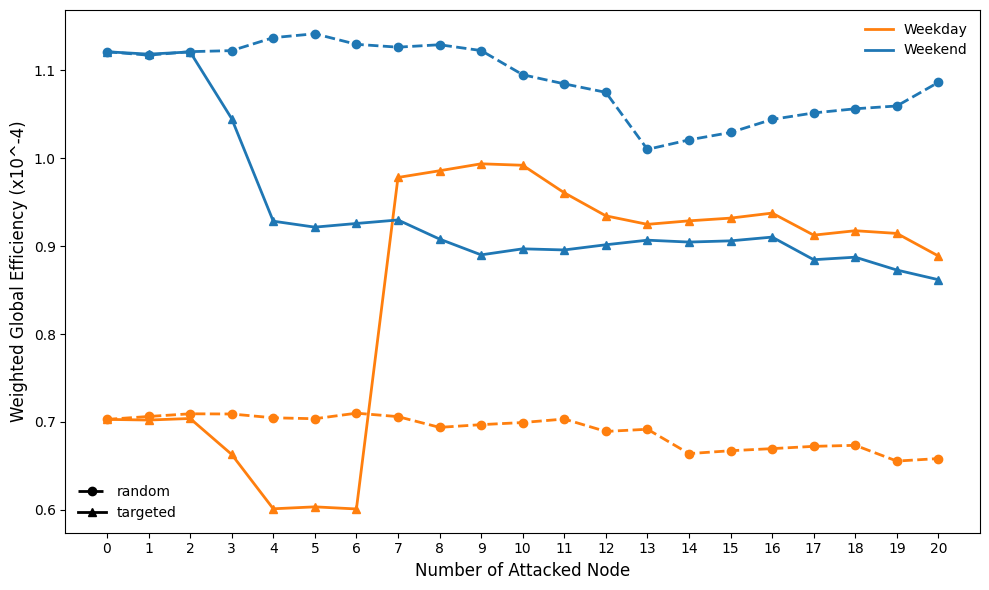

In [ ]:
# Define custom colors for each network
network_colors = {
    #'Friday': '#1f77b4',  # Blue
    'Weekday': '#ff7f0e',  # Orange
    'Weekend': '#1f77b4',  # Green
    #'Sunday': '#d62728'  # Red
}

# Define line styles for attack types
attack_styles = {
    'random': '--',  # Dashed line
    'targeted': '-'  # Solid line
}
markers = {
    'random': 'o',
    'targeted': '^'
}
# Create the plot
plt.figure(figsize=(10, 6))

# Create the plot
#plt.figure(figsize=(12, 8))

# Plot the data
for network_name, df in results.items():
    for attack_type in ['random', 'targeted']:
        subset = df[df['Attack_Type'] == attack_type].copy()  # Copy the subset to avoid warnings
        subset.loc[:, 'Iteration_numeric'] = range(len(subset))  # Use .loc to set the new column
        plt.plot(
            subset['Iteration_numeric'],
            subset['Efficiency (x10^-4)'],
            color=network_colors[network_name],
            marker=markers[attack_type],
            linestyle=attack_styles[attack_type],
            linewidth=2,
            label=f"{network_name}" if attack_type == 'random' else None,  # Add label only once per network
        )

# Add legend for networks (color and marker legend)
network_legend_handles = [
    plt.Line2D(
        [0], [0],
        color=color,
        lw=2,  # Line width for better visibility
        label=network_name
    )
    for network_name, color in network_colors.items()
]
network_legend = plt.legend(
    handles=network_legend_handles,
    loc="upper right",
    fontsize=10,
    frameon=False
)

# Add legend for attack types (linestyle and marker legend)
attack_legend_handles = [
    plt.Line2D(
        [0], [0],
        color='black',
        linestyle=style,
        marker=markers[attack_type],
        lw=2,
        label=attack_type
    )
    for attack_type, style in attack_styles.items()
]
attack_legend = plt.legend(
    handles=attack_legend_handles,
    loc="lower left",
    fontsize=10,
    frameon=False
)

# Add the network legend back to the plot
plt.gca().add_artist(network_legend)


# Customize plot
plt.xlabel('Number of Attacked Node', fontsize=12)
plt.ylabel('Weighted Global Efficiency (x10^-4)', fontsize=12)
#plt.title('Comparison of Random and Targeted Attacks Across Networks', fontsize=16)
plt.xticks(range(21), fontsize=10)  # Ensure x-axis labels are 0-10
plt.yticks(fontsize=10)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/INFSCI_2125_Final_project/output/attack_weighted.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

### Topological Network Attack

In [ ]:
def topo_simulate_node_attacks_with_betweenness_and_random(G, top_n=20):
    """
    Simulates targeted (based on betweenness centrality) and random node attacks,
    and calculates the efficiency after each attack.

    Parameters
    ----------
    G : :class:`networkx.Graph`
        The input graph for simulation.
    weight : str
        The edge attribute used as the weight for shortest path computation.
    v_weight : str
        The edge attribute used for calculating betweenness centrality.
    top_n : int
        Number of nodes to remove for the attacks.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing results of efficiency changes for targeted and random attacks.
    """
    # Make copies of the graph to avoid modifying the original
    G_copy_targeted = G.copy()
    G_copy_random = G.copy()

    # Step 1: Compute betweenness centrality
    betweenness = nx.betweenness_centrality(G_copy_targeted, normalized=False)
    nx.set_node_attributes(G_copy_targeted, betweenness, 'Betweenness_W')

    # Step 2: Sort nodes by betweenness centrality for targeted attack
    sorted_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n]
    targeted_nodes = [node for node, _ in sorted_nodes]

    # Step 3: Randomly select nodes for random attack
    random_nodes = random.sample(list(G_copy_random.nodes()), top_n)

    # Initialize results
    results = []

    # Step 4: Perform targeted attack
    initial_efficiency = nx.global_efficiency(G_copy_targeted)
    results.append(('targeted', 'original', initial_efficiency))
    for idx, node in enumerate(targeted_nodes):
        G_copy_targeted.remove_node(node)
        efficiency = nx.global_efficiency(G_copy_targeted)
        results.append(('targeted', f'iteration_{idx + 1}', efficiency))

    # Step 5: Perform random attack
    initial_efficiency_random = nx.global_efficiency(G_copy_random)
    results.append(('random', 'original', initial_efficiency_random))
    for idx, node in enumerate(random_nodes):
        G_copy_random.remove_node(node)
        efficiency = nx.global_efficiency(G_copy_random)
        results.append(('random', f'iteration_{idx + 1}', efficiency))

    # Convert results to DataFrame
    # Extract only the significant digits and mark the unit as e-6
    df_results = pd.DataFrame(
        [(attack, iteration, efficiency) for attack, iteration, efficiency in results],
        columns=['Attack_Type', 'Iteration', 'Efficiency']
    )

    return df_results

In [ ]:
topo_result = topo_simulate_node_attacks_with_betweenness_and_random(G_topo, top_n=20)

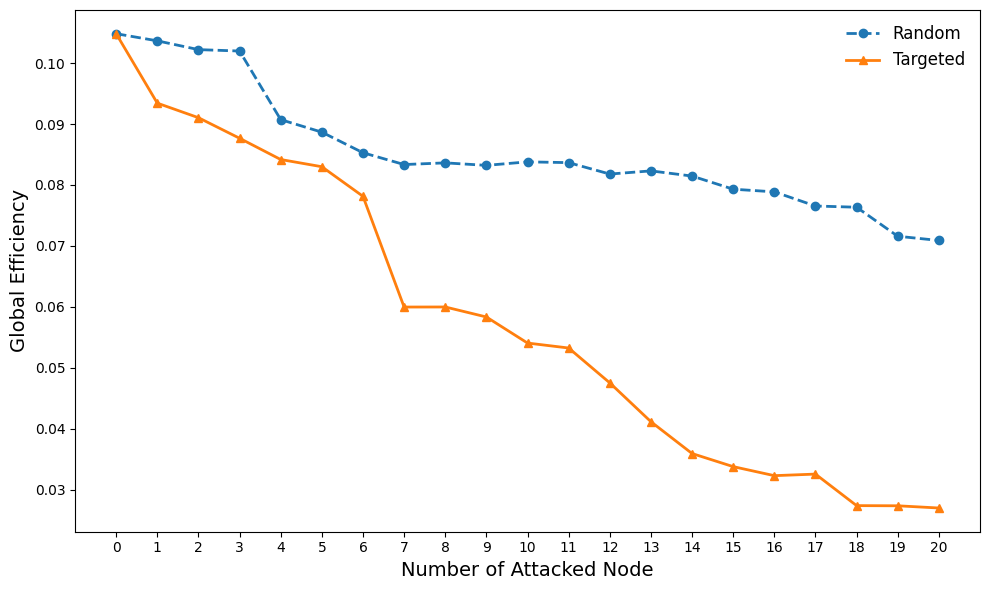

In [ ]:
topo_result = topo_simulate_node_attacks_with_betweenness_and_random(G_topo, top_n=20)


attack_styles = {
    'random': '--',
    'targeted': '-'
}
markers = {
    'random': 'o',
    'targeted': '^'
}

## Plotting
plt.figure(figsize=(10, 6))

for attack_type in ['random', 'targeted']:
    subset = topo_result[topo_result['Attack_Type'] == attack_type].copy()
    subset['Iteration_numeric'] = range(len(subset))
    plt.plot(
        subset['Iteration_numeric'],
        subset['Efficiency'],
        linestyle=attack_styles[attack_type],
        marker=markers[attack_type],
        linewidth=2,
        label=attack_type.capitalize()
    )

plt.xlabel('Number of Attacked Node', fontsize=14)
plt.ylabel('Global Efficiency', fontsize=14)
# plt.title('Efficiency Changes Under Random and Targeted Attacks', fontsize=16)
plt.legend(fontsize=12, frameon=False)
plt.xticks(range(21), fontsize=10)
# plt.grid(alpha=0.3)
plt.tight_layout()


plt.savefig("/content/drive/MyDrive/INFSCI_2125_Final_project/output/attack_topological.png", dpi=300, bbox_inches='tight')
plt.show()